# Thermal Conductivity from EMD
## Introduction
In this example, we use the EMD (Green-Kubo) method to calculate the lattice thermal conductivity of graphene at 300 K and zero pressure.

### Importing Relevant Functions
The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [thermo](https://github.com/AlexGabourie/thermo) package.

In [1]:
from pylab import *
from ase.build import graphene_nanoribbon
from thermo.gpumd.data import load_hac
from ase.io import write

##. Preparing the Inputs
The model.xyz file used is the same as in density of states tutorial.
We use a Tersoff potential [[Tersoff 1989]](https://doi.org/10.1103/PhysRevB.39.5566) parameterized by Lindsay *et al.* [[Lindsay 2010]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.205441).
Note that the thickness of the graphene sheet is set to 3.35 $\mathring A$ according to the convention in the literature. This thickness is needed to calculate an effective 3D thermal conductivity for a 2D material.

### Generate the model.xyz file

In [2]:
gnr = graphene_nanoribbon(60, 36, type='armchair', sheet=True, vacuum=3.35/2, C_C=1.44)
gnr.euler_rotate(theta=90)
l = gnr.cell.lengths()
gnr.cell = gnr.cell.new((l[0], l[2], l[1]))
l = l[2]
gnr.center()
gnr.pbc = [True, True, False]
gnr

Atoms(symbols='C8640', pbc=[True, True, False], cell=[149.64918977395098, 155.52, 3.35])

In [3]:
write("model.xyz", gnr)

- The first few lines of the [model.xyz](https://gpumd.zheyongfan.org/index.php/The_model.xyz_input_file) file are:
```
8640
Lattice="149.64918977395098 0.0 0.0 0.0 155.52 0.0 0.0 0.0 3.35" Properties=species:S:1:pos:R:3 pbc="T T F"
C      147.77857490       0.72000000       1.67500000
C      149.02565148       1.44000000       1.67500000
C      149.02565148       2.88000000       1.67500000
C      147.77857490       3.60000000       1.67500000
```

- Explanations for the first line:
  - The first number states that the number of particles is 8640.

- Explanations for the second line:
   - This line consists of a number of keyword=value pairs separated by spaces. Spaces before and after = are allowed. All the characters are case-insensitive.
   - lattice="ax ay az bx by bz cx cy cz" gives the box vectors.
   - properties=property_name:data_type:number_of_columns. We only read the following items:
        - species:S:1 atom type (Mandatory)
        - pos:R:3 position vector (Mandatory)
        - mass:R:1 mass (Optional: default mass values will be used when this is missing), not included here.
        - vel:R:3 velocity vector (Optional), not included here.
        - group:I:number_of_grouping_methods grouping methods (Optional), not included here.
   -  pbc="pbc_a pbc_b pbc_c", where pbc_a, pbc_b, and pbc_c can only be T or F, which means box is periodic or non-periodic (free, or open) in the a, b, and c directions. 

### The <code>run.in</code> file
The <code>run.in</code> input file is given below:<br>
```
potential   ../../../potentials/tersoff/Graphene_Lindsay_2010_modified.txt
velocity    300

ensemble    npt_ber 300 300 100 0 0 0 53.4059 53.4059 53.4059 2000
time_step   1     
dump_thermo 100     
run         1000000

ensemble    nve
compute_hac 20 50000 10
run         10000000
```
- The first line uses the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword to define the potential to be used, which is specified in the file [Graphene_Lindsay_2010_modified.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Graphene_Lindsay_2010_modified.txt).

- The second line uses the [velocity](https://gpumd.zheyongfan.org/index.php/The_velocity_keyword) keyword and sets the velocities to be initialized with a temperature of 300 K. 

- There are two runs.
  - The first [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) serves as the equilibration stage, where the NPT [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) (the Berendsen barostat) is used. The temperature is 300 K and the pressures are zero in all the directions. The coupling constants are 100 and 2000 time steps for the thermostat and the barostat (The elastic constant, or inverse compressibility parameter needed in the barostat is estimated to be 53.4059 GPa; this only needs to be correct up to the order of magnitude.), respectively. The [time_step](https://gpumd.zheyongfan.org/index.php/The_time_step_keyword) for integration is 1 fs. There are $10^6$ steps (1 ns) for this [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) and the thermodynamic quantities will be output every 1000 steps.
  - The second [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) is for production. Here, the NVE [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) is used. The line with the [compute_hac](https://gpumd.zheyongfan.org/index.php/The_compute_hac_keyword) keyword means that heat currents will be recorded every 20 steps (20 fs), 50000 HAC data (the maximum correlation time is then about 1 ns) will be calculated, and the HAC are averaged for every 10 data points before written out. The production time is 10 ns ($10^7$ steps), which is 10 times as long as the maximum correlation time. This is a reasonable choice.

## Results and Discussion
### Computation Time
- The results below are from three independent runs, which took about 2.5 hours in total using a GeForce RTX 2080 Ti GPU.

### Figure Properties

In [4]:
aw = 2
fs = 16
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

### Plot HAC (heat current autocorrelations) & RTC (running thermal conductivity)
 - The hac.out output file is loaded and processed to create the following figure.

In [5]:
hac = load_hac([50000]*3, [10]*3)
print(hac.keys())
print(hac['run0'].keys())

dict_keys(['run0', 'run1', 'run2'])
dict_keys(['t', 'jxijx', 'jxojx', 'jyijy', 'jyojy', 'jzjz', 'kxi', 'kxo', 'kyi', 'kyo', 'kz'])


In [6]:
t = hac['run0']['t']
hac_ave_i = np.zeros(hac['run0']['jxijx'].shape[0])
hac_ave_o = np.zeros_like(hac_ave_i)
ki_ave, ko_ave = np.zeros_like(hac_ave_i), np.zeros_like(hac_ave_o)
for runkey in hac.keys():
    hac_ave_i += hac[runkey]['jxijx']+hac[runkey]['jyijy']
    hac_ave_o += hac[runkey]['jxojx']+hac[runkey]['jyojy']
    ki_ave += (hac[runkey]['kxi']+hac[runkey]['kyi'])
    ko_ave += (hac[runkey]['kxo']+hac[runkey]['kyo'])
hac_ave_i /= hac_ave_i.max()
hac_ave_o /= hac_ave_o.max()
ki_ave /= 6.
ko_ave /= 6.

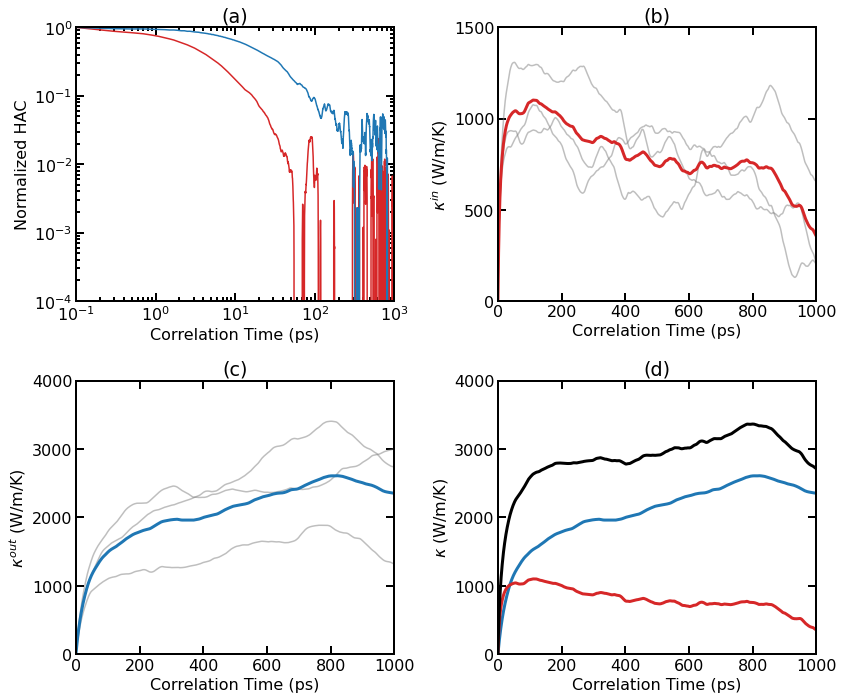

In [7]:
figure(figsize=(12,10))
subplot(2,2,1)
set_fig_properties([gca()])
loglog(t, hac_ave_i, color='C3')
loglog(t, hac_ave_o, color='C0')
xlim([1e-1, 1e3])
ylim([1e-4, 1])
xlabel('Correlation Time (ps)')
ylabel('Normalized HAC')
title('(a)')

subplot(2,2,2)
set_fig_properties([gca()])
for runkey in hac.keys():
    plot(hac[runkey]['t'], (hac[runkey]['kxi']+hac[runkey]['kyi'])/2, color='C7',alpha=0.5)
plot(t, ki_ave, color='C3', linewidth=3)
xlim([0, 1000])
gca().set_xticks(range(0,1001,200))
ylim([0, 1500])
gca().set_yticks(range(0,1501,500))
xlabel('Correlation Time (ps)')
ylabel(r'$\kappa^{in}$ (W/m/K)')
title('(b)')

subplot(2,2,3)
set_fig_properties([gca()])
for runkey in hac.keys():
    plot(hac[runkey]['t'], (hac[runkey]['kxo']+hac[runkey]['kyo'])/2, color='C7',alpha=0.5)
plot(t, ko_ave, color='C0', linewidth=3)
xlim([0, 1000])
gca().set_xticks(range(0,1001,200))
ylim([0, 1500])
gca().set_yticks(range(0,4001,1000))
xlabel('Correlation Time (ps)')
ylabel(r'$\kappa^{out}$ (W/m/K)')
title('(c)')

subplot(2,2,4)
set_fig_properties([gca()])
plot(t, ko_ave, color='C0', linewidth=3)
plot(t, ki_ave, color='C3', linewidth=3)
plot(t, ki_ave + ko_ave, color='k', linewidth=3)
xlim([0, 1000])
gca().set_xticks(range(0,1001,200))
ylim([0, 1500])
gca().set_yticks(range(0,4001,1000))
xlabel('Correlation Time (ps)')
ylabel(r'$\kappa$ (W/m/K)')
title('(d)')

tight_layout()
show()

Thermal conductivity results for pristine graphene at 300 K from EMD simulations. **(a)** Normalized HAC as a function of correlation time for the in-plane and out-of-plane components. **(b)** Individual (thin lines) and averaged (thick line) RTC as a function of correlation time for the in-plane component. **(c)** Individual (thin lines) and averaged (thick line) RTC as a function of correlation time for the out-of-plane component. **(d)** Averaged RTC as a function of correlation time for various components.

## Results
- As the system is essentially isotropic in the planar directions, we only consider a scalar thermal conductivity $\kappa=(\kappa_{xx}+\kappa_{yy})/2$ for the 2D system. However, we consider the *in-out decomposition* as introduced in [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309).
- From **(a)**, we can see that the in-plane component and the out-of-plane component of the HAC have different time scales. The latter decays much more slowly. 
- Panel **(b)** shows the individual and averaged RTCs for the in-plane component $\kappa^{\rm in}(t)$. The averaged RTC converges to about 1000 W/m/K at around 100 ps. 
- Panel **(c)** shows the individual and averaged RTCs for the out-of-plane component $\kappa^{\rm out}(t)$, and the convergence property is not very clear here. This is because the out-of-plane component converges very slowly and three independent simulations (each with 10 ns) are not enough to give accurate results. 
- Summing up $\kappa^{\rm in}(t)$ and $\kappa^{\rm out}(t)$, we get $\kappa^{\rm tot}(t)$, as shown in panel **(d)**.

## Discussion
- Accurately calculating thermal conductivity of graphene using the EMD method can be a very time consuming task. The results we presented here are from three independent simulations with a total production time of 30 ns. It can been seen that the HAC data already become very noisy when the correlation time is 100 ps. To obtain accurate results, one needs to do many independent simulations. Much more accurate data were presented in Fig. 2 of [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309). Here are the simulation parameters used in [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309) which differ from those used in this example:
  - The simulation cell size used in [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309) is larger, which is about 25 nm x 25 nm (24000 atoms), instead of 15 nm x 15 nm (8640 atoms) here.
  - The maximum correlation time used in [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309) is larger, which is 10 ns, instead of 1 ns here.
  - The production time used in [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309) for one independent simulation is larger, which is 50 ns, instead of 10 ns here.
  - There were 100 independent simulations in [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309), instead of 3 here. Therefore, the total production time used in [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309) is 5000 ns.
  - Each independent simulation in [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309) took about 10 GPU hours (using Tesla K40) and about 1000 GPU hours were used to obtain the results shown in Fig. 2 of [[Fan 2017]](https://doi.org/10.1103/PhysRevB.95.144309).
  - We see that the EMD method can be very time consuming. A more efficient method of computing thermal conductivity is the HNEMD method, which is discussed in HNEMD tutorial

## References
- [Fan 2017] Zheyong Fan, Luiz Felipe C. Pereira, Petri Hirvonen, Mikko M. Ervasti, Ken R. Elder, Davide Donadio, Tapio Ala-Nissila, and Ari Harju, [Thermal conductivity decomposition in two-dimensional materials: Application to graphene](https://doi.org/10.1103/PhysRevB.95.144309), Phys. Rev. B **95**, 144309 (2017).
- [Lindsay 2010] L. Lindsay and D.A. Broido, [Optimized Tersoff and Brenner emperical potential parameters for lattice dynamics and phonon thermal transport in carbon nanotubes and graphene](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B, **81**, 205441 (2010).
- [Tersoff 1989] J. Tersoff, [Modeling solid-state chemistry: Interatomic potentials for multicomponent systems](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B 39, 5566(R) (1989).